<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/DM_1_kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nearest Neighbor Classifier Implementation

In this lab session, the objective is to do a simple implementation of one of the simplest machine learning methods: [Nearest neighbor classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). Given a training set of n training examples each with d features and known class label, the nearest neighbor classifier works by finding the eculidean distance of a test example whose class label is not known with all examples in the training set and assigning the label of the nearest training example to the test example. Essentially, it predicts the class label of a test example based on the label of its closest (or least dissimilar) training example. A more generic variant of the classifier, called a k-nearest neighbor (kNN) classifier works by predicting the label of a test example based on majority of k-nearest training examples. The nearest neighbor classifier thus becomes a special case of this classifer with k=1.

We will be doing the following tasks:

1. Generating and visualizing some (toy) data
2. Implementing a distance function
3. Implementing a nearest neighbor classifier function and generating predictions for test data
4. Implementing a function to calculate accuracy
5. Implementing a nearest neighbor classifier as a class
6. Using built-in (sklearn) implementation of k-nearest neighbor classifier

# 1. Generating and visualizing data

Functions for generating and visualizing data are provided below. You do not need to change anything for this. The getExamples function below will generate a numpy array X which contains n training examples in d = 2 dimensions and a vector y which contains the corresponding binary class labels (+1 or -1) of these examples. The plotit function will simply do a scatter plot of these training examples in the feature space. 

Note that the semantic meaning of the features or the labels is irrelevant here. The two features may correspond to "whiteness" and "computer screens" in the pathologist vs. computer scientist example we discussed in the class or they can be anything else. For this exercise, we have used Gaussian random number generation to generate two sets of points: positive class (y=+1) examples centered at  (+1,+1) and negative class (y=-1) examples centered at (-1,-1) in the feature space. Essentially, getExamples models the real world phenomenon that is generating our data.

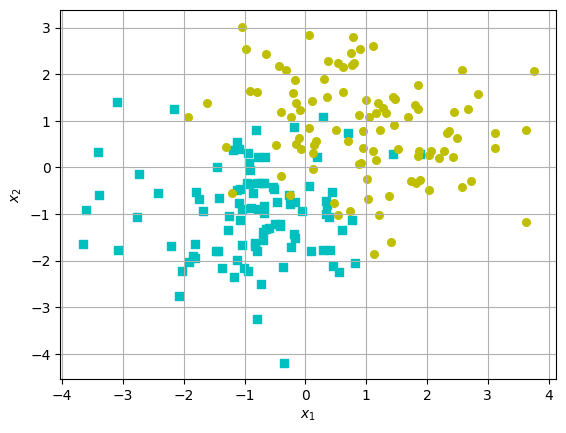

[np.float64(-3.6605128356619043),
 np.float64(3.75345642734812),
 np.float64(-4.188337009600448),
 np.float64(3.024519871761936)]

In [2]:
import numpy as np #importing numpy
from numpy.random import randn,randint #importing randn
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    DO NOT EDIT (from: https://github.com/foxtrotmike/plotit)
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)        
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:            
            conts = sorted([-1+eps,0,1-eps])
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent

def getExamples(n=100,d=2):
    """
    DO NOT EDIT
    Generates n d-dimensional normally distributed examples of each class        
    The mean of the positive class is [1] and for the negative class it is [-1]
    """
    Xp = randn(n,d)#+1   #generate n examples of the positie class
    Xp=Xp+1
    Xn = randn(n,d)#-1   #generate n examples of the negative class
    Xn=Xn-1
    X = np.vstack((Xp,Xn))  #Stack the examples together to a single matrix
    Y = np.array([+1]*n+[-1]*n) #Associate Labels
    return (X,Y) 


X,Y = getExamples()
plotit(X = X, Y = Y)

# 2. Implementing the Euclidean Distance Function

[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between two vectors $p$ and $q$ in d-dimensional space is given by: $d(p,q) = \sqrt{\sum_{i=1}^{d} (p_i-q_i)^2}$. 

Please implement the function distance below that can be used to calculate the Euclidean distance between two points. 

In [3]:
def distance(p,q):
    """
    Input:
        p: (1xd) numpy vector of 1 training examples each with d features
        q: (1xd) numpy vector of 1 training examples each with d features        
    Return:
        d: Euclidean Distance
    """
    # Put your code here

    return np.sqrt(np.dot(p - q, p - q))

Test the correctness of your implementation by finding the distance between a number of points and verifying through hand calculations

In [4]:
print(distance(np.array([0,0]),np.array([1,1])))
print(distance(np.array([1,1]),np.array([0,0])))
print(distance(np.array([-1,-5]),np.array([1,0])))

1.4142135623730951
1.4142135623730951
5.385164807134504


Once you have ensured that your function calculates the distance correctly. Please move onto the next step. 

For the following steps, you are free to use any other (more efficient) implementation of the distance function as well. 

# 3. Implementing a nearest neighbor function

In this part of the exercise, we will be implementing a function implementation of the the nearest neighbor classifier. 

However, before that, we will generate some test data. Here, we use the same function getExamples to generate it. Practically, the labels of the test examples will not be known ahead of time. However, for this implementation, we get the labels as well. However, we will NEVER use test labels in training or building our classifier. We can use them to evaluate how good or bad is the classifier (performance evaluation).

In [5]:
Xtest,Ytest = getExamples(n=100,d=2)

In [6]:
def NN(Xtr,Ytr,Xtt):
    """
    Input:
        Xtr: (n x d) numpy matrix of n training examples each with d features
        Ytr: (n) dimensional numpy vector matrix of training labels
        Xtt: (m x d) numpy matrix of m testing examples each with d features
    Return:
        Ypred: (m) dimensional numpy vector matrix of testing labels
    TO IMPLEMENT:
        A nearest neighbor classifier
        For each example in Xtt, find its closest example in Xtr
        You can find the euclidean distance between two examples
        Associate the label of the nearest training example to the testing one
        Construct a vector Y with the label of each testing example 
    
    """
    # Put your code here
    Ytt = np.zeros(Xtt.shape[0])
    for i in range(Xtt.shape[0]):
        dists = np.zeros(Xtr.shape[0])
        for j in range(dists.shape[0]):
            dists[j] = distance(Xtt[i], Xtr[j])
        index = np.argmin(dists)
        Ytt[i] = Ytr[index]
    return Ytt

In order to get output from your classifier, you will need to pass training examples (features and class-labels) as well as test data (features only!). Here we do a very simple test to see what is the class label for an example whose feature is [-1,-1]. What do you think its class label should be? You should check the label by printing Ypred.

In [7]:
ypred = NN(X,Y,np.array([[-1,-1]]))

Test your implementation of the nearest neighbor classifier on multiple examples to see that your implementation is correct. Then use it to generate labels for Xtest we generated above.

In [8]:
Ypred = NN(X,Y,Xtest)

# 4. Accuracy Calculation

The above code will generate labels for each test examples using the classifier. We now need to implement a function that, given Ypred and Ytest, tells us how accurate the predictor is. Accuracy is defined as the number of examples for which the prediction label is equal to the test label.

In [9]:
def accuracy(Ytest,Ypred):
    # to do: calculate accuracy
    # input:
    # Ytest: nx1 vector of labels (true)
    # Ypred: nx1 vector of labels (predicted)
    return np.sum(Ytest == Ypred) / Ypred.shape[0]

Use your function to calculate the accuracy of your predictor. 

In [10]:
print(accuracy(Ytest,Ypred))

0.87


Once you are done calculating the accuracy, you can use the following code to visualize the classification boundary of your predictor.

/tmp/dcs-tmp.u2101693/ipykernel_82872/798015659.py:59: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


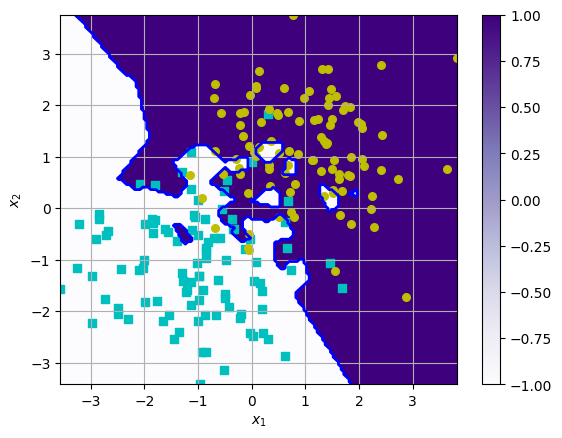

[np.float64(-3.5685271225134065),
 np.float64(3.828710282417128),
 np.float64(-3.4231103600455057),
 np.float64(3.7533343573858042)]

In [11]:
def clf(Xtest): # do not edit
    return NN(X,Y,Xtest)
plotit(Xtest,Y=Ytest,clf=clf,conts=[0])

# 5. Class based implementation

In order to understand how object oriented programming works in Python, we will now implement the same classifier as a class.

In [12]:
class myNN:
    """
    Nearest Neighbor Implementation
    """
    def __init__(self):
        self.X = []
        self.Y = []
    def fit(self,X,Y):        
        self.X = X
        self.Y = Y        
    def predict(self,Xtt):
        Ytt = np.zeros(Xtt.shape[0])
        for i in range(Xtt.shape[0]):
            dists = np.zeros(self.X.shape[0])
            for j in range(dists.shape[0]):
                dists[j] = distance(Xtt[i], self.X[j])
            index = np.argmin(dists)
            Ytt[i] = self.Y[index]
        return Ytt

nn = myNN()
nn.fit(X,Y)
Ypred = nn.predict(Xtest)

Do test the accuracy of your predictor. Once you are done calculating the accuracy, you can use the following code to visualize the classification boundary of your predictor.

0.87


/tmp/dcs-tmp.u2101693/ipykernel_82872/798015659.py:59: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


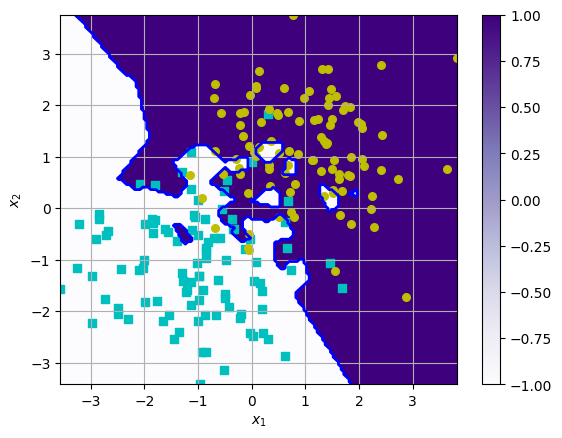

[np.float64(-3.5685271225134065),
 np.float64(3.828710282417128),
 np.float64(-3.4231103600455057),
 np.float64(3.7533343573858042)]

In [13]:
print(accuracy(Ypred,Ytest))
plotit(X=Xtest,Y=Ytest,clf=nn.predict,conts=[0]) # do not edit

# 6. Using sk-learn

Our basic implementation of the nearest neighbor classifier is quite inefficient and tedious as it is meant as an exercise to practice Python. Fortunately, Python provides an excellent package called Scikit-Learn which provides a very [efficient tree-based implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) of k-nearest neighbor which is conceptually very similar to our implementation.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
sknn = KNeighborsClassifier(n_neighbors=1)
sknn.fit(X,Y)

KNeighborsClassifier(n_neighbors=1)

You can also use the accuracy function that is builtin for Sk-learn. Please verify that your implementation generates the same accuracy as the builtin one for the test data. You can use the following code to visualize the boundary.

/tmp/dcs-tmp.u2101693/ipykernel_82872/798015659.py:59: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


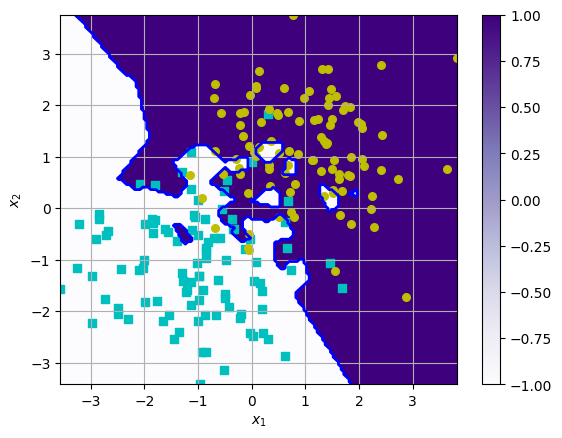

[np.float64(-3.5685271225134065),
 np.float64(3.828710282417128),
 np.float64(-3.4231103600455057),
 np.float64(3.7533343573858042)]

In [15]:
plotit(X=Xtest,Y=Ytest,clf=sknn.predict,conts=[0]) # do not edit

# Questions: 

Here are a few questions for you to think about:

> What is the accuracy of the nearest neighbor classifier (k = 1) on TRAINING Data? Why?

The accuracy on the training data is 1.0. This is because for every training point, the closest point is itself, therefore the classifier correctly classifies every point.

> What is the accuracy of the nearest neighbor classifier (k = 1) on test Data?

The accuracy on the test data is 0.87. 

> What is the accuracy of k = 3 nearest neighbor classifier (k = 3) on TRAINING Data?

0.925. The classifier no longer only takes into account the training point itself, but also the ones nearby. It can be interpreted as meaning that 92.5% of the points have the same class label as themselves plus at least one of the two nearest points. 

> What is the accuracy of k = 3 nearest neighbor classifier (k = 3) on test Data?

0.915

> What is the accuracy of k = 31 nearest neighbor classifier (k = 31) on TRAINING Data?
0.91
> What is the accuracy of k = 31 nearest neighbor classifier (k = 31) on test Data?
0.93
> Can you build an intuitive understanding of what's going on here by looking at the classification boundaries for different k?

Looking at the decision boundaries we can see that as $k$ grows, the decision boundary becomes more and more generalised. It's overfitting less to the training data. When $k$ is 1, overfitting is high because only the nearest couple of points are considered. When $k$ is high, more points are considered. At high $k$ it learns a much more general boundary. 

Interesting side note: when $k = n$, i.e. all samples are considered, then the classifier must always predict the majority class. If the classes are split evenly, then it achieves an accuracy of 50%. 


In [36]:
Y_train_pred = sknn.predict(X)
print(accuracy(Y_train_pred, Y))

1.0


In [18]:
nn3 = KNeighborsClassifier(n_neighbors=3)
nn3.fit(X,Y)
Y_train_pred3 = nn3.predict(X)
print(accuracy(Y_train_pred3, Y))
Ypred3 = nn3.predict(Xtest)
print(accuracy(Ypred3, Ytest))


0.925
0.915


In [41]:
nn31 = KNeighborsClassifier(n_neighbors=10)
nn31.fit(X,Y)
Y_train_pred31 = nn31.predict(X)
print(accuracy(Y_train_pred31, Y))
Ypred31 = nn31.predict(Xtest)
print(accuracy(Ypred31, Ytest))

0.915
0.93


/tmp/dcs-tmp.u2101693/ipykernel_82872/798015659.py:59: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


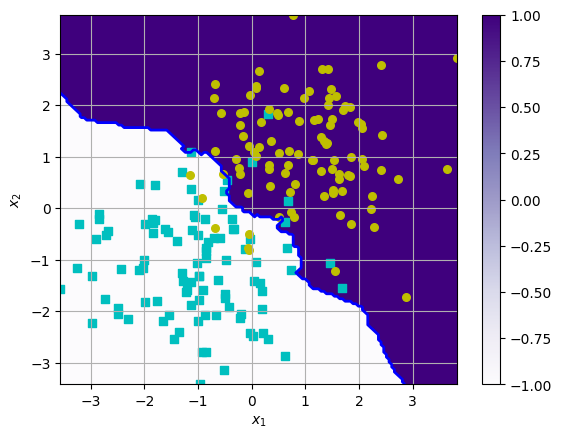

[np.float64(-3.5685271225134065),
 np.float64(3.828710282417128),
 np.float64(-3.4231103600455057),
 np.float64(3.7533343573858042)]

In [42]:
plotit(X=Xtest,Y=Ytest,clf=nn31.predict,conts=[0]) # do not edit